---
# IAR MINI-PROJECT
## LunarLanderContinuous-v2/v3 with DDPG and TD3
## Investigating the impact of Over-Estimation Bias
### Tarık Ege EKEN (21110611) / Kaan DİŞLİ (21113004)
---

# ===== IMPORTS =====
---

In [27]:
# ===============================
import os
from pathlib import Path
import time
import numpy as np 
import matplotlib.pyplot as plt

# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
print(f"Using torch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ===============================
import gymnasium as gym
import pygame as pg
print(f"Using gym version: {gym.__version__}")
print(f"Using pygame version: {pg.__version__}")

Using torch version: 2.8.0+cu129
Using device: cuda
Using gym version: 1.2.1
Using pygame version: 2.6.1


---

# 1. MANUAL PLAY
---

In [2]:
def get_color(score):
    """
    Optional function to color the text based on the score.
    green >= 90
    red-yellow-green gradient (-90, 90)
    red <= -90
    """
    if score >= 90:
        return (0, 255, 0)  # Green
    elif score <= -90:
        return (255, 0, 0)  # Red
    else:
        # Gradient from red to green
        ratio = (score + 90) / 180
        r = int(255 * (1 - ratio))
        g = int(255 * ratio)
        return (r, g, 0)

In [3]:
env = gym.make('LunarLanderContinuous-v3', render_mode='human')
pg.font.init()
font = pg.font.SysFont('Futura', 20)
obs, info = env.reset()
done = False
ep_count = 0
rewards = []
total_reward = 0.0

while not done:
    for event in pg.event.get():
        if event.type == pg.QUIT:
            done = True
        elif event.type == pg.KEYDOWN:
            if event.key == pg.K_ESCAPE:
                done = True

    keys = pg.key.get_pressed()
    action = np.array([0.0, 0.0], dtype=np.float32)
    average_reward = np.mean(rewards) if rewards else 0.0
    lines = [
    f"Episode: {ep_count}",
    f"Current Reward: {total_reward:.2f}",
    f"Last Reward: {rewards[-1] if rewards else 0:.2f}",
    f"Average Reward: {average_reward:.2f}"
    ]
    screen = pg.display.get_surface()  # Get the current display surface
    if screen:
        y_offset = 10  # Start drawing from y=10
        for line in lines:
            color = get_color(total_reward) if "Current Reward" in line else (255, 255, 255)
            text_surface = font.render(line, True, color)
            screen.blit(text_surface, (10, y_offset))  # Top-left corner of the screen
            y_offset += text_surface.get_height() + 5  # Add spacing between lines

    pg.display.update()  # Update the display


    if keys[pg.K_UP]:
        action[0] = 1.0  # Main engine
    if keys[pg.K_LEFT]:
        action[1] = -1.0  # Left side engine
    if keys[pg.K_RIGHT]:
        action[1] = 1.0  # Right side engine

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    if terminated or truncated:
        ep_count += 1
        rewards.append(total_reward)
        print(f"\nEpisode {ep_count} - Reward: {total_reward:.2f}\n")
        env.reset()
        total_reward = 0.0

env.close()
pg.quit()


Episode 1 - Reward: -116.48


Episode 2 - Reward: 43.57


Episode 2 - Reward: 43.57


Episode 3 - Reward: -61.21


Episode 3 - Reward: -61.21


Episode 4 - Reward: 292.99


Episode 4 - Reward: 292.99


Episode 5 - Reward: 294.94


Episode 5 - Reward: 294.94


Episode 6 - Reward: 1.60


Episode 6 - Reward: 1.60


Episode 7 - Reward: 198.24


Episode 7 - Reward: 198.24


Episode 8 - Reward: 50.76


Episode 8 - Reward: 50.76


Episode 9 - Reward: 231.37


Episode 9 - Reward: 231.37


Episode 10 - Reward: 6.13


Episode 10 - Reward: 6.13


Episode 11 - Reward: -6.10


Episode 11 - Reward: -6.10


Episode 12 - Reward: -8.02


Episode 12 - Reward: -8.02


Episode 13 - Reward: 281.95


Episode 13 - Reward: 281.95


Episode 14 - Reward: -0.06


Episode 14 - Reward: -0.06


Episode 15 - Reward: -118.97


Episode 15 - Reward: -118.97


Episode 16 - Reward: -37.35


Episode 16 - Reward: -37.35


Episode 17 - Reward: 14.48


Episode 17 - Reward: 14.48


Episode 18 - Reward: 246.41


Episode 18 - 

---

# 2. RANDOM AGENT
---

In [4]:
env = gym.make('LunarLanderContinuous-v3', render_mode='human')
pg.font.init()
font = pg.font.SysFont('Futura', 20)
obs, info = env.reset()
done = False
ep_count = 0
rewards = []
total_reward = 0.0

while not done:
    for event in pg.event.get():
        if event.type == pg.QUIT:
            done = True
        elif event.type == pg.KEYDOWN:
            if event.key == pg.K_ESCAPE:
                done = True

    # sample random action
    action = env.action_space.sample()
    average_reward = np.mean(rewards) if rewards else 0.0
    lines = [
    f"Episode: {ep_count}",
    f"Current Reward: {total_reward:.2f}",
    f"Last Reward: {rewards[-1] if rewards else 0:.2f}",
    f"Average Reward: {average_reward:.2f}"
    ]
    screen = pg.display.get_surface()  # Get the current display surface
    if screen:
        y_offset = 10  # Start drawing from y=10
        for line in lines:
            color = get_color(total_reward) if "Current Reward" in line else (255, 255, 255)
            text_surface = font.render(line, True, color)
            screen.blit(text_surface, (10, y_offset))  # Top-left corner of the screen
            y_offset += text_surface.get_height() + 5  # Add spacing between lines

    pg.display.update()  # Update the display

    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    if terminated or truncated:
        ep_count += 1
        rewards.append(total_reward)
        print(f"\nEpisode {ep_count} - Reward: {total_reward:.2f}\n")
        env.reset()
        total_reward = 0.0

env.close()
pg.quit()


Episode 1 - Reward: -243.07


Episode 2 - Reward: -237.26


Episode 2 - Reward: -237.26


Episode 3 - Reward: -353.28


Episode 3 - Reward: -353.28


Episode 4 - Reward: -25.39


Episode 4 - Reward: -25.39


Episode 5 - Reward: -159.99


Episode 5 - Reward: -159.99



---

# 3. SIMPLE LINEAR GENETIC ALGORITHM
---

### Testing the performance of an agent trained with a simple genetic algorithm. Using evolutionary algorithms that conserve the fittest individuals in each generation and mutate them slightly to create a new generation.

In [128]:
# ===== PARAMETERS =====
generation_count = 300   # Number of generations (iterations)

# Essentially the size of the model
population_size = 40    # Population size

# Essentially the learning rate
selection_rate = 0.3    # Proportion of population to keep
mutation_rate = 0.2     # Mutation rate
mutation_strength = 0.5 # Standard deviation of mutation noise 

verbose = True          # Print info about each generation
extra_verbose = False   # Print detailed info about each individual
# ===============================

In [129]:
print(f"Observations are in {obs.shape} shape, so we need the weights to be of shape ({env.action_space.shape[0]}, {obs.shape[0]}) so that the dot product gives us the correct action shape.\n")

# ===== SIMPLE LINEAR GENETIC ALGORITHM =====
class SimpleGAAgent:
    def __init__(self):
        self.genome = np.random.uniform(-1, 1, (env.action_space.shape[0], obs.shape[0]))

    def get_action(self, obs):
        # Simple linear policy: action = W * obs
        action = np.dot(self.genome, obs)
        return np.clip(action, -1, 1)

    def mutate(self, mutation_rate, mutation_strength):
        mutation_mask = np.random.rand(*self.genome.shape) < mutation_rate
        mutations = np.random.normal(0, mutation_strength, self.genome.shape)
        self.genome += mutation_mask * mutations
        self.genome = np.clip(self.genome, -1, 1)

    def save_state_dict(self, filename):
        # Ensure the directory exists
        os.makedirs("params", exist_ok=True)
        try:
            np.save(Path("params", filename), self.genome)
        except Exception as e:
            print(f"Error saving state dict: {e}")

    def load_state_dict(self, filename):
        try:
            self.genome = np.load(Path("params", filename), allow_pickle=True)
        except Exception as e:
            print(f"Error loading state dict: {e}")
# ==========================================

simple_ga_agent = SimpleGAAgent()
print(f"Genome shape: {simple_ga_agent.genome.shape}")
print(f"Initial random action from SimpleGAAgent: {simple_ga_agent.get_action(obs)}")
simple_ga_agent.mutate(mutation_rate, mutation_strength)
print(f"Action after mutation from SimpleGAAgent: {simple_ga_agent.get_action(obs)}")

Observations are in (8,) shape, so we need the weights to be of shape (2, 8) so that the dot product gives us the correct action shape.

Genome shape: (2, 8)
Initial random action from SimpleGAAgent: [ 1.         -0.51597415]
Action after mutation from SimpleGAAgent: [ 1.         -0.51597415]


In [130]:
env = gym.make('LunarLanderContinuous-v3')
start = time.time()

best_generation_rewards = []
average_generation_rewards = []

generation_success_rates = []

agent_rewards = []
population = [SimpleGAAgent() for _ in range(population_size)]
selection_count = int(population_size * selection_rate)

best_agent_of_each_generation = []

print(f"Selecting the top {selection_count} out of {population_size} agents each generation\n")
for generation in range(generation_count):
    if verbose:
        if extra_verbose or (generation % max(1, generation_count // 10) == 0):
            print(f"\n=== Generation {generation + 1} / {generation_count} - Time: {time.time() - start:.2f}s ===")
    fitness_scores = []
    agent_rewards_temp = []
    agent_success_count = 0
    for idx, agent in enumerate(population):
        obs, info = env.reset()
        done = False
        total_reward = 0.0

        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated

        if reward == 100:
            agent_success_count += 1

        fitness_scores.append((total_reward, agent))
        agent_rewards_temp.append(total_reward)
        if extra_verbose:
            print(f"\tAgent {generation+1}.{idx + 1} - Reward: {total_reward:.2f} - Time: {time.time() - start:.2f}s")

    fitness_scores.sort(key=lambda x: x[0], reverse=True)
    best_agents = [agent for _, agent in fitness_scores[:selection_count]]
    if verbose:
        if extra_verbose or (generation % max(1, generation_count // 10) == 0):
            print(f"Best Reward this Generation: {fitness_scores[0][0]:.2f}")
            print(f"Average Reward this Generation: {np.mean(agent_rewards_temp):.2f}")
            print(f"Success Rate this Generation: {agent_success_count} / {population_size} ({(agent_success_count / population_size) * 100:.2f}%)")

    best_agent_of_each_generation.append(fitness_scores[0][1])
    best_generation_rewards.append(fitness_scores[0][0])
    average_generation_rewards.append(np.mean(agent_rewards_temp))
    generation_success_rates.append((agent_success_count / population_size) * 100)
    agent_rewards.append(agent_rewards_temp)
    new_population = best_agents.copy()
    while len(new_population) < population_size:
        parent = np.random.choice(best_agents)
        child = SimpleGAAgent()
        child.genome = np.copy(parent.genome)
        child.mutate(mutation_rate, mutation_strength)
        new_population.append(child)
    population = new_population


if verbose:
    print(f"\n=== Generation {generation_count} / {generation_count} - Time: {time.time() - start:.2f}s ===")
    print(f"Best Reward this Generation: {fitness_scores[0][0]:.2f}")
    print(f"Average Reward this Generation: {np.mean(agent_rewards_temp):.2f}")
    print(f"Success Rate this Generation: {agent_success_count} / {population_size} ({(agent_success_count / population_size) * 100:.2f}%)")


env.close()
# ==========================================
best_generation = np.argmax(average_generation_rewards)
best_average = average_generation_rewards[best_generation]
final_time = time.time() - start

print(f"\n===========\nTraining completed in {final_time:.2f}s.\n")
print(f"Best generation's (Gen {best_generation + 1}) reward average: {best_average:.2f}, reward range: ({min(agent_rewards[best_generation])} - {max(agent_rewards[best_generation])}), success rate: {generation_success_rates[best_generation]:.2f}%\n")
print("===========\n")

# save the best agent of the last generation
best_agent = fitness_scores[0][1]
best_agent.save_state_dict(f"best_simple_ga_agent_{int(time.time())}")

Selecting the top 12 out of 40 agents each generation


=== Generation 1 / 300 - Time: 0.00s ===
Best Reward this Generation: -70.40
Average Reward this Generation: -591.91
Success Rate this Generation: 0 / 40 (0.00%)

=== Generation 31 / 300 - Time: 5.62s ===
Best Reward this Generation: 212.14
Average Reward this Generation: -45.73
Success Rate this Generation: 2 / 40 (5.00%)

=== Generation 61 / 300 - Time: 11.37s ===
Best Reward this Generation: 248.65
Average Reward this Generation: -35.09
Success Rate this Generation: 2 / 40 (5.00%)

=== Generation 91 / 300 - Time: 17.66s ===
Best Reward this Generation: 236.54
Average Reward this Generation: -13.10
Success Rate this Generation: 1 / 40 (2.50%)

=== Generation 121 / 300 - Time: 24.45s ===
Best Reward this Generation: 212.34
Average Reward this Generation: -130.04
Success Rate this Generation: 1 / 40 (2.50%)

=== Generation 151 / 300 - Time: 35.27s ===
Best Reward this Generation: 298.54
Average Reward this Generation: -21.01
Succe

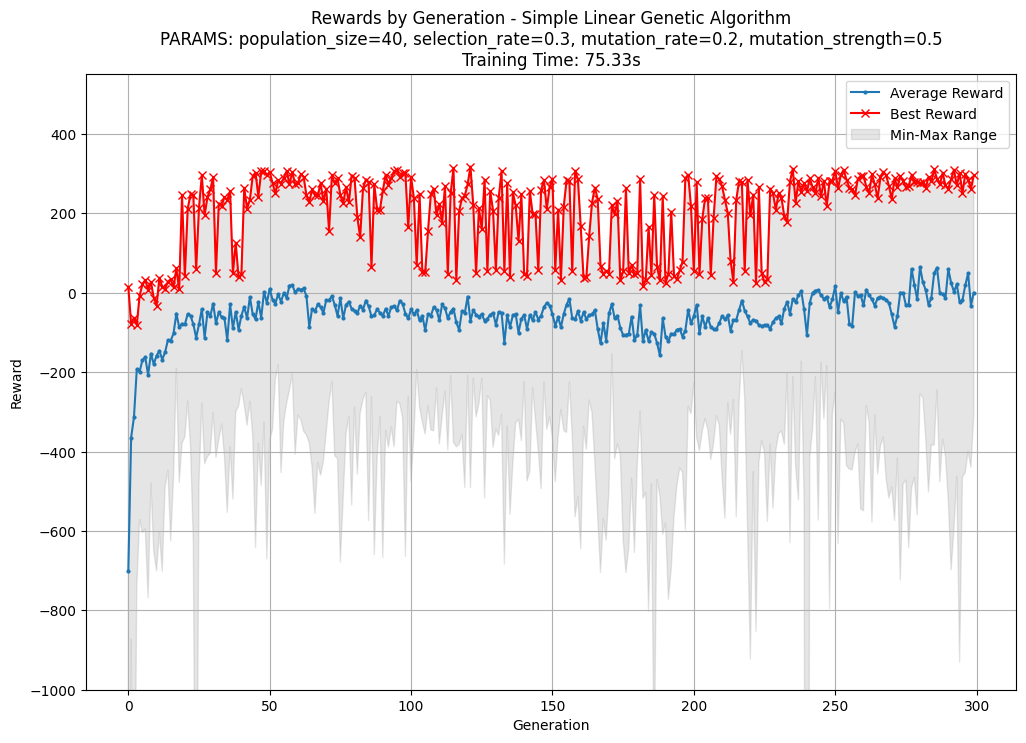

In [39]:
# PLOT RESULTS
plt.figure(figsize=(12, 8))
plt.plot(average_generation_rewards, marker='o', markersize=2, label='Average Reward')
plt.plot(best_generation_rewards, marker='x', color="red", label='Best Reward')
plt.fill_between(range(generation_count), 
                 [min(gen_rewards) for gen_rewards in agent_rewards], 
                 [max(gen_rewards) for gen_rewards in agent_rewards], 
                 color='gray', alpha=0.2, label='Min-Max Range')
plt.title(f'Rewards by Generation - Simple Linear Genetic Algorithm\nPARAMS: {population_size=}, {selection_rate=}, {mutation_rate=}, {mutation_strength=}\nTraining Time: {final_time:.2f}s')
plt.xlabel('Generation')
plt.ylabel('Reward')
ylim_bottom, ylim_top = plt.ylim()
plt.ylim(-1000, ylim_top + 10)
plt.grid()
plt.legend()
plt.show()

In [53]:
def run_agent_model(agent_model, human_view=True, max_episodes=10, verbose=True, extra_verbose=False):
    if human_view:
        env = gym.make('LunarLanderContinuous-v3', render_mode='human')
        pg.font.init()
        font = pg.font.SysFont('Futura', 20)
    else:
        env = gym.make('LunarLanderContinuous-v3')
    obs, info = env.reset()
    done = False
    ep_count = 0
    rewards = []
    successes = []
    total_reward = 0.0
    while (not done) and (ep_count < max_episodes):
        if human_view:
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    done = True
                elif event.type == pg.KEYDOWN:
                    if event.key == pg.K_ESCAPE:
                        done = True

        action = agent_model.get_action(obs)
        average_reward = np.mean(rewards) if rewards else 0.0
        if human_view:
            lines = [
            f"Episode {ep_count} / {max_episodes}",
            f"Current Reward: {total_reward:.2f}",
            f"Last Reward: {rewards[-1] if rewards else 0:.2f}",
            f"Average Reward: {average_reward:.2f}"
            ]
            screen = pg.display.get_surface()  # Get the current display surface
            if screen:
                y_offset = 10  # Start drawing from y=10
                for line in lines:
                    color = get_color(total_reward) if "Current Reward" in line else (255, 255, 255)
                    text_surface = font.render(line, True, color)
                    screen.blit(text_surface, (10, y_offset))  # Top-left corner of the screen
                    y_offset += text_surface.get_height() + 5  # Add spacing between lines
            pg.display.update()  # Update the display
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            ep_count += 1
            if reward == 100:
                successes.append(1)
            else:
                successes.append(0)
            rewards.append(total_reward)
            if verbose:
                if extra_verbose or (ep_count % max(1, max_episodes // 10) == 0):
                    print(f"Episode {ep_count} - Reward: {total_reward:.2f} - Average Reward: {np.mean(rewards):.2f} - Success Rate: {100 * np.mean(successes):.2f}%\n")
            env.reset()
            total_reward = 0.0
    env.close()
    pg.quit()
    print(f"Finished running {ep_count} episodes.")
    print(f"Average Reward over {ep_count} episodes: {np.mean(rewards):.2f}")
    print(f"Success Rate over {ep_count} episodes: {100 * np.mean(successes):.2f}%")
    return rewards, successes

In [ ]:
# save the best agent model parameters as "PARAMS_best_simple_ga_agent.npy" to be loaded again
best_agent = best_agent_of_each_generation[best_generation]
print("Saving best Simple GA agent parameters to '/params/best_simple_ga_agent.npy'")
best_agent.save_state_dict("best_simple_ga_agent.npy")
loaded_agent = SimpleGAAgent()
print("Loading Simple GA agent parameters from '/params/best_simple_ga_agent.npy'")
loaded_agent.load_state_dict("best_simple_ga_agent.npy")

Saving best Simple GA agent parameters to '/params/best_simple_ga_agent.npy'
Loading Simple GA agent parameters from '/params/best_simple_ga_agent.npy'


Episode 100 - Reward: 265.60 - Average Reward: 123.81 - Success Rate: 51.00%

Episode 200 - Reward: 260.09 - Average Reward: 138.28 - Success Rate: 58.00%

Episode 300 - Reward: 240.93 - Average Reward: 139.88 - Success Rate: 57.33%

Episode 400 - Reward: 182.77 - Average Reward: 140.76 - Success Rate: 57.25%

Episode 500 - Reward: 249.12 - Average Reward: 140.59 - Success Rate: 57.40%

Episode 600 - Reward: 243.59 - Average Reward: 139.07 - Success Rate: 57.17%

Episode 700 - Reward: 40.84 - Average Reward: 137.07 - Success Rate: 55.71%

Episode 800 - Reward: -45.88 - Average Reward: 136.07 - Success Rate: 55.00%

Episode 900 - Reward: 1.41 - Average Reward: 134.38 - Success Rate: 54.56%

Episode 1000 - Reward: 38.98 - Average Reward: 134.59 - Success Rate: 54.90%

Finished running 1000 episodes.
Average Reward over 1000 episodes: 134.59
Success Rate over 1000 episodes: 54.90%


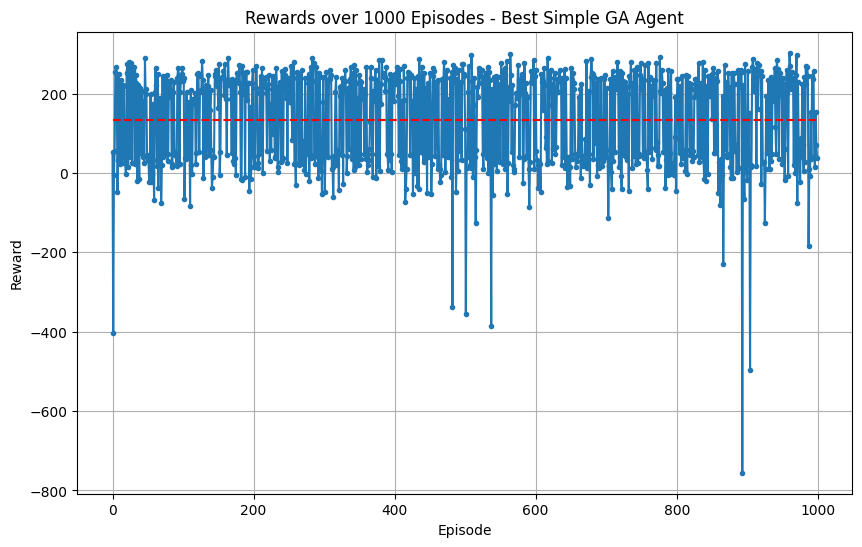

In [133]:
# run the model from the best generation
max_episodes = 1000
best_agent_rewards, best_agent_successes = run_agent_model(loaded_agent, human_view=False, max_episodes=max_episodes, verbose=True, extra_verbose=False)
plt.figure(figsize=(10, 6))
plt.plot(best_agent_rewards, marker='o', markersize=3)
# line for the final average
plt.plot([np.mean(best_agent_rewards)] * len(best_agent_rewards), linestyle='--', color='r')
plt.title(f'Rewards over {max_episodes} Episodes - Best Simple GA Agent')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()

In [134]:
# run the model from the best generation
max_episodes = 20
best_agent_rewards = run_agent_model(loaded_agent, human_view=True, max_episodes=max_episodes, verbose=True, extra_verbose=True)


Episode 1 - Reward: 226.99 - Average Reward: 226.99 - Success Rate: 100.00%

Episode 2 - Reward: 27.22 - Average Reward: 127.11 - Success Rate: 50.00%

Episode 3 - Reward: 191.30 - Average Reward: 148.50 - Success Rate: 66.67%

Episode 4 - Reward: 227.49 - Average Reward: 168.25 - Success Rate: 75.00%

Episode 5 - Reward: -117.31 - Average Reward: 111.14 - Success Rate: 60.00%

Episode 6 - Reward: 64.41 - Average Reward: 103.35 - Success Rate: 50.00%

Episode 7 - Reward: 256.09 - Average Reward: 125.17 - Success Rate: 57.14%

Episode 8 - Reward: 33.49 - Average Reward: 113.71 - Success Rate: 50.00%

Episode 9 - Reward: 36.69 - Average Reward: 105.15 - Success Rate: 44.44%

Episode 10 - Reward: 171.90 - Average Reward: 111.83 - Success Rate: 50.00%

Episode 11 - Reward: 191.94 - Average Reward: 119.11 - Success Rate: 54.55%

Episode 12 - Reward: 38.08 - Average Reward: 112.36 - Success Rate: 50.00%

Episode 13 - Reward: 229.53 - Average Reward: 121.37 - Success Rate: 53.85%

Episode 14 

# 4. DDPG ALGORITHM
---

In [92]:
class MLP(nn.Module):

    def __init__(self, input_size, output_size, config=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, config),
            nn.ReLU(),
            nn.Linear(config, config),
            nn.ReLU(),
            nn.Linear(config, output_size),
        )

    def forward(self, x):
        return self.net(x)



class Actor(nn.Module): 
    
    def __init__(self, hidden_size=64, learning_rate=1e-4, noise=0.2):
        super().__init__()
        self.actor_network = MLP(8, 2, hidden_size).to(device)
        self.actor_target_network = MLP(8, 2, hidden_size).to(device)
        self.actor_target_network.load_state_dict(self.actor_network.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor_network.parameters(), lr=learning_rate)
        self.tanh = nn.Tanh()
        self.noise = noise

    def estimate_best_action_env(self, state):
        a =  self.tanh(self.actor_network(torch.as_tensor(state, dtype=torch.float32, device=device))) 
        
        a += self.noise * torch.randn_like(a)
        return a.clamp(-1, 1)
  
    
    def estimate_best_action_training(self, state):
        return self.tanh(self.actor_network(torch.as_tensor(state, dtype=torch.float32, device=device))).clamp(-1,1)

    def estimate_best_action_target(self, state):
        a =  self.tanh(self.actor_target_network(torch.as_tensor(state, dtype=torch.float32, device=device)))
        return a
    
    def get_action(self, state):
        return self.estimate_best_action_env(state).cpu().detach().numpy()
        
    def update(self,batch,critic):
        S, A, S2, R, D = batch             
        Pi = self.tanh(self.actor_network(S))     
        Q  = critic.estimate_q_value(S, Pi)   
        loss = -Q.mean()
        self.actor_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        self.actor_optimizer.step()
        self.update_networks()
            

        
    def update_networks(self,tau=0.005):
        for target_param, param in zip(self.actor_target_network.parameters(), self.actor_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


class Critic(nn.Module):
    actor = None
    def __init__(self, hidden_size=64, learning_rate=1e-3, discount_factor=0.99, alpha=0.1):
        super().__init__()
        self.critic_network = MLP(10, 1, hidden_size).to(device)
        self.critic_target_network = MLP(10, 1, hidden_size).to(device)
        self.critic_target_network.load_state_dict(self.critic_network.state_dict())
        self.discount_factor = discount_factor
        self.alpha = alpha
        self.critic_optimizer = torch.optim.Adam(self.critic_network.parameters(), lr=learning_rate)


    def _to_batch(self,x):
        t = torch.as_tensor(x, dtype=torch.float32, device=device)
        return t if t.ndim > 1 else t.unsqueeze(0)

    def estimate_q_value(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)
        return self.critic_network(torch.cat([S, A], dim=-1))  

    def estimate_q_value_target(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)

        return self.critic_target_network(torch.cat([S, A], dim=-1))  

    

    def update(self,batch,actor):
    
        initial_state, action , observation, reward, terminated = batch
        
        with torch.no_grad():
            best_action = actor.estimate_best_action_target(observation)
            evaluate_future_action = self.estimate_q_value_target(observation, best_action) * (1 - terminated)
            target_q = reward + self.discount_factor * evaluate_future_action
        predicted_q = self.estimate_q_value(initial_state,action)
        loss = F.mse_loss(predicted_q,target_q)
        self.critic_optimizer.zero_grad()
        loss.backward() #we need to update the true critic network not the target
        self.critic_optimizer.step()
        self.update_networks()

    def update_networks(self,tau=0.005):
        for target_param, param in zip(self.critic_target_network.parameters(), self.critic_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

class DDPG_train():
    def __init__(self, batch_size=64, actor_hidden_size=64, critic_hidden_size=64, actor_lr=1e-4, critic_lr=1e-3, noise=0.2, discount_factor=0.99, alpha=0.1, capacity=10000):
        self.replay_buffer = []
        self.actor = Actor(hidden_size=actor_hidden_size, learning_rate=actor_lr, noise=noise)
        self.critic = Critic(hidden_size=critic_hidden_size, learning_rate=critic_lr, discount_factor=discount_factor, alpha=alpha)

        self.capacity = capacity
        self.batch_size = batch_size    

    def load_batch(self, batch_size):
        idx = np.random.choice(len(self.replay_buffer), size=batch_size, replace=False)
        S, A, S2, R, D = zip(*[self.replay_buffer[i] for i in idx])
        S  = torch.as_tensor(np.stack(S),  dtype=torch.float32, device=device)
        A  = torch.as_tensor(np.stack(A),  dtype=torch.float32, device=device)
        S2 = torch.as_tensor(np.stack(S2), dtype=torch.float32, device=device)
        R  = torch.as_tensor(np.array(R)[:,None], dtype=torch.float32, device=device)
        D  = torch.as_tensor(np.array(D)[:,None], dtype=torch.float32, device=device)
        return S, A, S2, R, D

    
    def replay_buffer_add(self,initial_state, action , obs, reward, terminated):
        self.replay_buffer.append((np.asarray(initial_state), np.asarray(action), np.asarray(obs), np.asarray(reward), np.asarray(terminated)))
        if len(self.replay_buffer) > self.capacity:
            self.replay_buffer.pop(0)

    def train(self):
        for _ in range(1):
            batch = self.load_batch(self.batch_size)
            self.critic.update(batch,self.actor)
            self.actor.update(batch,self.critic)

    def get_action(self, state):
        return self.actor.get_action(state)
    

    def save(self, path, meta=None):
        torch.save({
            'actor': self.actor.actor_network.state_dict(),
            'actor_target': self.actor.actor_target_network.state_dict(),
            'critic': self.critic.critic_network.state_dict(),
            'critic_target': self.critic.critic_target_network.state_dict(),
            'actor_opt': self.actor.actor_optimizer.state_dict(),
            'critic_opt': self.critic.critic_optimizer.state_dict(),
            # Warning: this can be big; keep it if you want to resume training exactly
            'replay_buffer': self.replay_buffer,
            'meta': meta or {},
        }, path)

    def load(self, path, map_location=device):
        ckpt = torch.load(path, map_location=map_location, weights_only=False)
        self.actor.actor_network.load_state_dict(ckpt['actor'])
        self.actor.actor_target_network.load_state_dict(ckpt['actor_target'])
        self.critic.critic_network.load_state_dict(ckpt['critic'])
        self.critic.critic_target_network.load_state_dict(ckpt['critic_target'])
        self.actor.actor_optimizer.load_state_dict(ckpt['actor_opt'])
        self.critic.critic_optimizer.load_state_dict(ckpt['critic_opt'])
        self.replay_buffer = ckpt.get('replay_buffer', [])
        return ckpt.get('meta', {})

In [93]:
# ===== PARAMETERS =====
iteration_count = 300   # Number of iterations

# Replay Buffer
batch_size = 64
capacity = 100000

# Actor
actor_hidden_size = 128
actor_lr = 1e-3
noise = 0.2

# Critic
critic_hidden_size = 128
critic_lr = 1e-3
discount_factor = 0.99
alpha = 0.1

verbose = True          # Print info about each generation
extra_verbose = False   # Print detailed info about each individual
# ===============================


env = gym.make('LunarLanderContinuous-v3')
start = time.time()

rewards = []
successes = []
ddpg_agent = DDPG_train(batch_size=batch_size,
                        actor_hidden_size=actor_hidden_size,
                        critic_hidden_size=critic_hidden_size,
                        actor_lr=actor_lr,
                        critic_lr=critic_lr,
                        noise=noise,
                        discount_factor=discount_factor,
                        alpha=alpha,
                        capacity=capacity)


for iteration in range(iteration_count):
    obs, info = env.reset()
    done = False
    total_reward = 0.0

    while not done:
        #action = ddpg_agent.get_action(obs)
        action = ddpg_agent.actor.estimate_best_action_env(obs).cpu().detach().numpy()
        new_obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
        ddpg_agent.replay_buffer_add(obs, action, new_obs, reward, done)
        if len(ddpg_agent.replay_buffer) >= batch_size:
            ddpg_agent.train()
        obs = new_obs

    successes.append(1 if reward == 100 else 0)
    rewards.append(total_reward)

    if verbose:
        if extra_verbose or (iteration % max(1, iteration_count // 10) == 0):
            print(f"\tIteration {iteration + 1} / {iteration_count} - Reward: {total_reward:.2f} - Average Reward in the last {max(1, iteration_count // 10)} episodes: {np.mean(rewards[-max(1, iteration_count // 10):]):.2f} - Success Rate: {100 * np.mean(successes[-max(1, iteration_count // 10):]):.2f}% - Time: {time.time() - start:.2f}s")

final_time = time.time() - start
if verbose:
    print(f"\n=== Final Iteration {iteration_count} / {iteration_count} - Reward: {total_reward:.2f} - Time: {final_time:.2f}s ===")
    print(f"Average Reward over last {max(1, iteration_count // 10)} iterations: {np.mean(rewards[-max(1, iteration_count // 10):]):.2f}")
    print(f"Success Rate over last {max(1, iteration_count // 10)} iterations: {np.mean(successes[-max(1, iteration_count // 10):]):.2f}")


env.close()
# ==========================================

# save the agent model
ddpg_agent.save(Path("params", f"ddpg_agent_{int(time.time())}.pt"))

	Iteration 1 / 300 - Reward: -262.80 - Average Reward in the last 30 episodes: -262.80 - Success Rate: 0.00 - Time: 0.37s
	Iteration 31 / 300 - Reward: -287.36 - Average Reward in the last 30 episodes: -412.89 - Success Rate: 0.00 - Time: 23.26s
	Iteration 61 / 300 - Reward: -171.73 - Average Reward in the last 30 episodes: -188.83 - Success Rate: 0.00 - Time: 68.94s
	Iteration 91 / 300 - Reward: -210.45 - Average Reward in the last 30 episodes: -185.21 - Success Rate: 0.00 - Time: 143.95s
	Iteration 121 / 300 - Reward: -44.64 - Average Reward in the last 30 episodes: -121.12 - Success Rate: 0.00 - Time: 285.58s
	Iteration 151 / 300 - Reward: -187.45 - Average Reward in the last 30 episodes: -56.61 - Success Rate: 0.10 - Time: 528.59s
	Iteration 181 / 300 - Reward: -15.72 - Average Reward in the last 30 episodes: 13.06 - Success Rate: 0.23 - Time: 720.02s
	Iteration 211 / 300 - Reward: 136.65 - Average Reward in the last 30 episodes: 30.39 - Success Rate: 0.33 - Time: 966.95s
	Iteratio

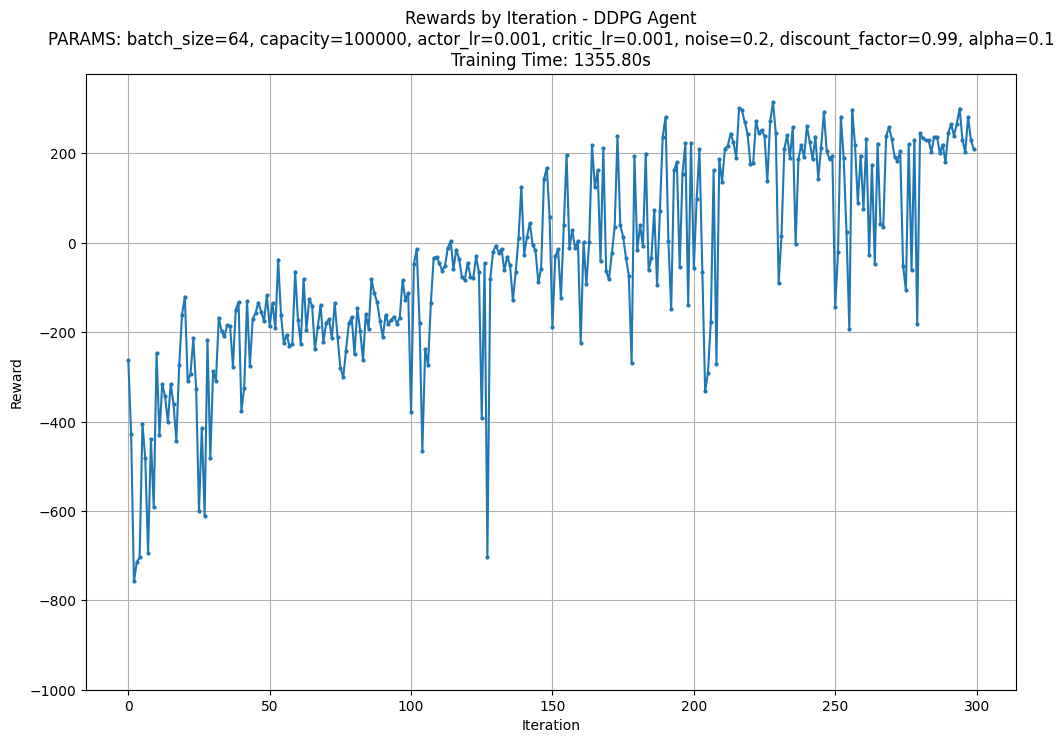

In [94]:
# PLOT RESULTS
plt.figure(figsize=(12, 8))
plt.plot(rewards, marker='o', markersize=2, label='Reward per Iteration')
plt.title(f'Rewards by Iteration - DDPG Agent\nPARAMS: {batch_size=}, {capacity=}, {actor_lr=}, {critic_lr=}, {noise=}, {discount_factor=}, {alpha=}\nTraining Time: {final_time:.2f}s')
plt.xlabel('Iteration')
plt.ylabel('Reward')
ylim_bottom, ylim_top = plt.ylim()
plt.ylim(-1000, max(200, ylim_top + 10))
plt.grid()
plt.show()

In [97]:
# save model
ddpg_agent.save(Path("params", "best_ddpg_agent.pt"))
print("Saved DDPG agent model to 'params/best_ddpg_agent.pt'")

Saved DDPG agent model to 'params/best_ddpg_agent.pt'


In [99]:
loaded_ddpg_agent = DDPG_train(batch_size=batch_size,
                                actor_hidden_size=actor_hidden_size,
                                critic_hidden_size=critic_hidden_size,
                                actor_lr=actor_lr,
                                critic_lr=critic_lr,
                                noise=noise,
                                discount_factor=discount_factor,
                                alpha=alpha,
                                capacity=capacity)
loaded_ddpg_agent.load(Path("params", "best_ddpg_agent.pt"))
print("Loaded DDPG agent model from 'params/best_ddpg_agent.pt'")

Loaded DDPG agent model from 'params/best_ddpg_agent.pt'


In [118]:
# ===== PARAMETERS =====
iteration_count = 300   # Number of iterations

# Replay Buffer
batch_size = 64
capacity = 100000

# Actor
actor_hidden_size = 128
actor_lr = 1e-3
noise = 0.2

# Critic
critic_hidden_size = 128
critic_lr = 1e-3
discount_factor = 0.99
alpha = 0.1
# ===============================
loaded_ddpg_agent2 = DDPG_train(batch_size=batch_size,
                                actor_hidden_size=actor_hidden_size,
                                critic_hidden_size=critic_hidden_size,
                                actor_lr=actor_lr,
                                critic_lr=critic_lr,
                                noise=noise,
                                discount_factor=discount_factor,
                                alpha=alpha,
                                capacity=capacity)
loaded_ddpg_agent2.load(Path("params", "ddpg_agent_1760709404.pt"))
print("Loaded temporary DDPG agent model from 'params/ddpg_agent_1760709404.pt'")

Loaded temporary DDPG agent model from 'params/ddpg_agent_1760709404.pt'


In [116]:
def run_agent_model_ddpg(agent_model, human_view=True, max_episodes=10, verbose=True, extra_verbose=False):
    if human_view:
        env = gym.make('LunarLanderContinuous-v3', render_mode='human')
        pg.font.init()
        font = pg.font.SysFont('Futura', 20)
    else:
        env = gym.make('LunarLanderContinuous-v3')
    obs, info = env.reset()
    done = False
    ep_count = 0
    rewards = []
    successes = []
    total_reward = 0.0
    while (not done) and (ep_count < max_episodes):
        if human_view:
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    done = True
                elif event.type == pg.KEYDOWN:
                    if event.key == pg.K_ESCAPE:
                        done = True

        action = agent_model.actor.estimate_best_action_env(obs).cpu().detach().numpy()
        average_reward = np.mean(rewards) if rewards else 0.0
        if human_view:
            lines = [
            f"Episode {ep_count} / {max_episodes}",
            f"Current Reward: {total_reward:.2f}",
            f"Last Reward: {rewards[-1] if rewards else 0:.2f}",
            f"Average Reward: {average_reward:.2f}"
            ]
            screen = pg.display.get_surface()  # Get the current display surface
            if screen:
                y_offset = 10  # Start drawing from y=10
                for line in lines:
                    color = get_color(total_reward) if "Current Reward" in line else (255, 255, 255)
                    text_surface = font.render(line, True, color)
                    screen.blit(text_surface, (10, y_offset))  # Top-left corner of the screen
                    y_offset += text_surface.get_height() + 5  # Add spacing between lines
            pg.display.update()  # Update the display
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated:
            ep_count += 1
            if reward == 100:
                successes.append(1)
            else:
                successes.append(0)
            rewards.append(total_reward)
            if verbose:
                if extra_verbose or (ep_count % max(1, max_episodes // 10) == 0):
                    print(f"Episode {ep_count} - Reward: {total_reward:.2f} - Average Reward: {np.mean(rewards):.2f} - Success Rate: {100 * np.mean(successes):.2f}%\n")
            env.reset()
            total_reward = 0.0
    env.close()
    pg.quit()
    print(f"Finished running {ep_count} episodes.")
    print(f"Average Reward over {ep_count} episodes: {np.mean(rewards):.2f}")
    print(f"Success Rate over {ep_count} episodes: {100 * np.mean(successes):.2f}%")
    return rewards, successes

Episode 10 - Reward: -191.83 - Average Reward: -55.76 - Success Rate: 0.00%

Episode 20 - Reward: 84.36 - Average Reward: -45.44 - Success Rate: 0.00%

Episode 30 - Reward: -180.02 - Average Reward: -38.02 - Success Rate: 0.00%

Episode 40 - Reward: -141.04 - Average Reward: -29.05 - Success Rate: 5.00%

Episode 50 - Reward: 103.30 - Average Reward: -18.12 - Success Rate: 4.00%

Episode 60 - Reward: 63.28 - Average Reward: -33.62 - Success Rate: 3.33%

Episode 70 - Reward: -47.64 - Average Reward: -37.14 - Success Rate: 2.86%

Episode 80 - Reward: 92.00 - Average Reward: -35.57 - Success Rate: 2.50%

Episode 90 - Reward: -255.95 - Average Reward: -34.11 - Success Rate: 2.22%

Episode 100 - Reward: -208.38 - Average Reward: -31.33 - Success Rate: 3.00%

Finished running 100 episodes.
Average Reward over 100 episodes: -31.33
Success Rate over 100 episodes: 3.00%


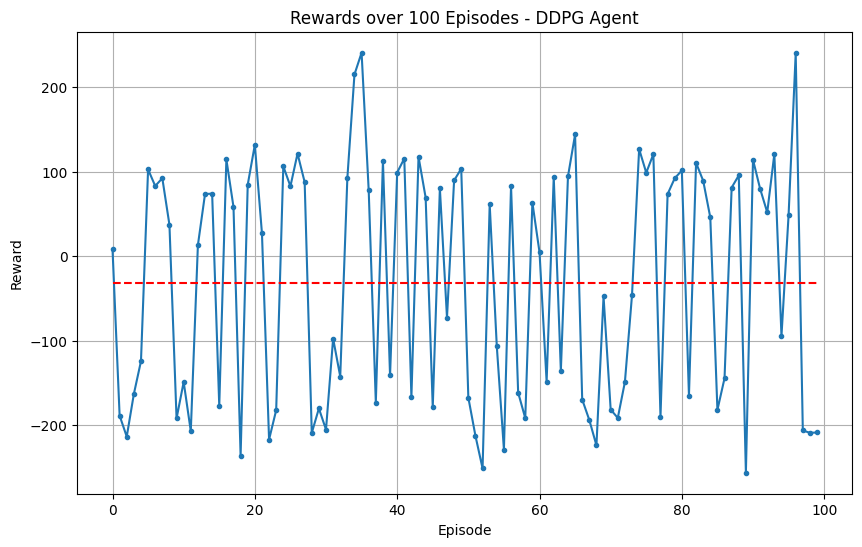

In [119]:
# run the trained DDPG agent
max_episodes = 100
ddpg_agent_rewards, ddpg_agent_successes = run_agent_model_ddpg(loaded_ddpg_agent2, human_view=False, max_episodes=max_episodes, verbose=True, extra_verbose=False)
plt.figure(figsize=(10, 6))
plt.plot(ddpg_agent_rewards, marker='o', markersize=3)
# line for the final average
plt.plot([np.mean(ddpg_agent_rewards)] * len(ddpg_agent_rewards), linestyle='--', color='r')
plt.title(f'Rewards over {max_episodes} Episodes - DDPG Agent')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()

In [ ]:
max_episodes = 3
ddpg_agent_rewards = run_agent_model_ddpg(loaded_ddpg_agent, human_view=True, max_episodes=max_episodes, verbose=True, extra_verbose=False)

Episode 1 - Reward: 104.32 - Average Reward: 104.32 - Success Rate: 0.00%

Episode 2 - Reward: 71.65 - Average Reward: 87.98 - Success Rate: 0.00%

Episode 3 - Reward: -2.62 - Average Reward: 57.78 - Success Rate: 0.00%

Finished running 3 episodes.
Average Reward over 3 episodes: 57.78
Success Rate over 3 episodes: 0.00%


In [121]:
max_episodes = 3
ddpg_agent_rewards = run_agent_model_ddpg(loaded_ddpg_agent2, human_view=True, max_episodes=max_episodes, verbose=True, extra_verbose=False)

Episode 1 - Reward: 132.47 - Average Reward: 132.47 - Success Rate: 0.00%

Episode 2 - Reward: -57.00 - Average Reward: 37.73 - Success Rate: 0.00%

Episode 3 - Reward: -205.84 - Average Reward: -43.46 - Success Rate: 0.00%

Finished running 3 episodes.
Average Reward over 3 episodes: -43.46
Success Rate over 3 episodes: 0.00%


# 5. TD3 ALGORITHM
---

In [108]:
class TD3_Actor(nn.Module): 
    
    def __init__(self, hidden_size=64, learning_rate=1e-4, noise=0.2):
        super().__init__()
        self.actor_network = MLP(8, 2, hidden_size).to(device)
        self.actor_target_network = MLP(8, 2, hidden_size).to(device)
        self.actor_target_network.load_state_dict(self.actor_network.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor_network.parameters(), lr=learning_rate)
        self.tanh = nn.Tanh()
        self.noise = noise

    def estimate_best_action_env(self, state):
        a =  self.tanh(self.actor_network(torch.as_tensor(state, dtype=torch.float32, device=device))) 
        
        a += self.noise * torch.randn_like(a)
        return a.clamp(-1, 1)
  
    
    def estimate_best_action_training(self, state):
        return self.tanh(self.actor_network(torch.as_tensor(state, dtype=torch.float32, device=device))).clamp(-1,1)

    def estimate_best_action_target(self, state):
        a =  self.tanh(self.actor_target_network(torch.as_tensor(state, dtype=torch.float32, device=device)))
        return a
    
    def get_action(self, state):
        return self.estimate_best_action_env(state).cpu().detach().numpy()
        
    def update(self,batch,critic):
        S, A, S2, R, D = batch             
        Pi = self.tanh(self.actor_network(S))   
        Q  = critic.estimate_q_value_1(S, Pi)   
        loss = -Q.mean()
        self.actor_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        self.actor_optimizer.step()
        self.update_networks()
            

        
    def update_networks(self,tau=0.005):
        for target_param, param in zip(self.actor_target_network.parameters(), self.actor_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


class TD3_Critic(nn.Module):
    actor = None
    def __init__(self, hidden_size=64, learning_rate=1e-3, discount_factor=0.99, alpha=0.1):
        super().__init__()
        self.critic_1_network = MLP(10, 1, hidden_size).to(device)
        self.critic_2_network = MLP(10, 1, hidden_size).to(device)
        self.critic_1_target_network = MLP(10, 1, hidden_size).to(device)
        self.critic_2_target_network = MLP(10, 1, hidden_size).to(device)
        self.critic_1_target_network.load_state_dict(self.critic_1_network.state_dict())
        self.critic_2_target_network.load_state_dict(self.critic_2_network.state_dict())
        self.discount_factor = discount_factor
        self.alpha = alpha
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1_network.parameters(), lr=learning_rate)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2_network.parameters(), lr=learning_rate)

    def _to_batch(self,x):
        t = torch.as_tensor(x, dtype=torch.float32, device=device)
        return t if t.ndim > 1 else t.unsqueeze(0)

    def estimate_q_value_1(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)
        return self.critic_1_network(torch.cat([S, A], dim=-1))  

    def estimate_q_value_2(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)
        return self.critic_2_network(torch.cat([S, A], dim=-1))

    def estimate_q_value_target_1(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)
        return self.critic_1_target_network(torch.cat([S, A], dim=-1))
    def estimate_q_value_target_2(self, state, action):
        S = self._to_batch(state); A = self._to_batch(action)
        return self.critic_2_target_network(torch.cat([S, A], dim=-1))
    

    def update(self,batch,actor):
    
        initial_state, action , observation, reward, terminated = batch
        
        with torch.no_grad():
            best_action = actor.estimate_best_action_target(observation)
            noise = (torch.randn_like(best_action) * actor.noise).clamp(-0.5, 0.5) 
            best_action = (best_action + noise).clamp(-1.0, 1.0)
            S = self._to_batch(observation); A = self._to_batch(best_action)
            q1 = self.critic_1_target_network(torch.cat([S, A], dim=-1))
            q2 = self.critic_2_target_network(torch.cat([S, A], dim=-1))
            evaluate_future_action = torch.min(q1,q2) * (1 - terminated)
            target_q = reward + self.discount_factor * evaluate_future_action
        predicted_q1 = self.estimate_q_value_1(initial_state,action)
        predicted_q2 = self.estimate_q_value_2(initial_state,action)
        loss1 = F.mse_loss(predicted_q1,target_q)
        loss2 = F.mse_loss(predicted_q2,target_q)

        self.critic_1_optimizer.zero_grad()
        loss1.backward() #we need to update the true critic network not the target
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        loss2.backward() #we need to update the true critic network not the target
        self.critic_2_optimizer.step()

        

    def update_networks(self,tau=0.005):
        for target_param, param in zip(self.critic_1_target_network.parameters(), self.critic_1_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(self.critic_2_target_network.parameters(), self.critic_2_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

class TD_train():
    def __init__(self, batch_size=64, actor_hidden_size=64, critic_hidden_size=64, actor_lr=1e-4, critic_lr=1e-3, noise=0.2, discount_factor=0.99, alpha=0.1, capacity=10000):
        self.replay_buffer = []
        self.actor = TD3_Actor(hidden_size=actor_hidden_size, learning_rate=actor_lr, noise=noise)
        self.critic = TD3_Critic(hidden_size=critic_hidden_size, learning_rate=critic_lr, discount_factor=discount_factor, alpha=alpha)

        self.capacity = capacity
        self.batch_size = batch_size    

    def load_batch(self, batch_size):
        idx = np.random.choice(len(self.replay_buffer), size=batch_size, replace=False)
        S, A, S2, R, D = zip(*[self.replay_buffer[i] for i in idx])
        S  = torch.as_tensor(np.stack(S),  dtype=torch.float32, device=device)
        A  = torch.as_tensor(np.stack(A),  dtype=torch.float32, device=device)
        S2 = torch.as_tensor(np.stack(S2), dtype=torch.float32, device=device)
        R  = torch.as_tensor(np.array(R)[:,None], dtype=torch.float32, device=device)
        D  = torch.as_tensor(np.array(D)[:,None], dtype=torch.float32, device=device)
        return S, A, S2, R, D

    
    def replay_buffer_add(self,initial_state, action , obs, reward, terminated):
        self.replay_buffer.append((np.asarray(initial_state), np.asarray(action), np.asarray(obs), np.asarray(reward), np.asarray(terminated)))
        if len(self.replay_buffer) > self.capacity:
            self.replay_buffer.pop(0)

    def train(self):
        for _ in range(1):
            batch = self.load_batch(self.batch_size)
            self.critic.update(batch,self.actor)
            self.actor.update(batch,self.critic)
            
    def get_action(self, state):
        return self.actor.get_action(state)


    def save(self, path, meta=None):
        ckpt = {
            # ---- actor ----
            'actor': self.actor.actor_network.state_dict(),
            'actor_target': self.actor.actor_target_network.state_dict(),
            'actor_opt': self.actor.actor_optimizer.state_dict(),

            # ---- twin critics ----
            'critic1': self.critic.critic_1_network.state_dict(),
            'critic2': self.critic.critic_2_network.state_dict(),
            'critic1_target': self.critic.critic_1_target_network.state_dict(),
            'critic2_target': self.critic.critic_2_target_network.state_dict(),
            'critic1_opt': self.critic.critic_1_optimizer.state_dict(),
            'critic2_opt': self.critic.critic_2_optimizer.state_dict(),

            # ---- extras ----
            'replay_buffer': self.replay_buffer,
            'meta': meta or {},
        }
        torch.save(ckpt, path)


    def load(self, path, map_location=device):
        ckpt = torch.load(path, map_location=map_location)

        # ---- actor ----
        self.actor.actor_network.load_state_dict(ckpt['actor'])
        self.actor.actor_target_network.load_state_dict(ckpt['actor_target'])
        self.actor.actor_optimizer.load_state_dict(ckpt['actor_opt'])

        # ---- twin critics ----
        self.critic.critic_1_network.load_state_dict(ckpt['critic1'])
        self.critic.critic_2_network.load_state_dict(ckpt['critic2'])
        self.critic.critic_1_target_network.load_state_dict(ckpt['critic1_target'])
        self.critic.critic_2_target_network.load_state_dict(ckpt['critic2_target'])
        self.critic.critic_1_optimizer.load_state_dict(ckpt['critic1_opt'])
        self.critic.critic_2_optimizer.load_state_dict(ckpt['critic2_opt'])

        # ---- extras ----
        self.replay_buffer = ckpt.get('replay_buffer', [])
        return ckpt.get('meta', {})

In [110]:
# ===== PARAMETERS =====
iteration_count = 300   # Number of iterations

# Replay Buffer
batch_size = 64
capacity = 10000

# Actor
actor_hidden_size = 128
actor_lr = 1e-4
noise = 0.2

# Critic
critic_hidden_size = 128
critic_lr = 1e-3
discount_factor = 0.99
alpha = 0.1

verbose = True          # Print info about each generation
extra_verbose = False   # Print detailed info about each individual
# ===============================


env = gym.make('LunarLanderContinuous-v3')
start = time.time()

rewards = []
successes = []
td3_agent = TD_train(batch_size=batch_size,
                        actor_hidden_size=actor_hidden_size,
                        critic_hidden_size=critic_hidden_size,
                        actor_lr=actor_lr,
                        critic_lr=critic_lr,
                        noise=noise,
                        discount_factor=discount_factor,
                        alpha=alpha,
                        capacity=capacity)


for iteration in range(iteration_count):
    obs, info = env.reset()
    done = False
    total_reward = 0.0
    total_steps = 0
    ddpg_warmup = 1000

    while not done:
        #action = td3_agent.get_action(obs) 
        # (warmup period)
        total_steps += 1
        if total_steps < ddpg_warmup:
            action = env.action_space.sample()
        else:
            action = td3_agent.actor.estimate_best_action_env(obs).cpu().detach().numpy()
        new_obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
        td3_agent.replay_buffer_add(obs, action, new_obs, reward, done)
        if len(td3_agent.replay_buffer) >= batch_size:
            td3_agent.train()
        obs = new_obs

    successes.append(1 if reward == 100 else 0)
    rewards.append(total_reward)

    if verbose:
        if extra_verbose or (iteration % max(1, iteration_count // 10) == 0):
            print(f"\tIteration {iteration + 1} / {iteration_count} - Reward: {total_reward:.2f} - Average Reward in the last {max(1, iteration_count // 10)} episodes: {np.mean(rewards[-max(1, iteration_count // 10):]):.2f} - Success Rate: {100 * np.mean(successes[-max(1, iteration_count // 10):]):.2f}% - Time: {time.time() - start:.2f}s")

final_time = time.time() - start
if verbose:
    print(f"\n=== Final Iteration {iteration_count} / {iteration_count} - Reward: {total_reward:.2f} - Time: {final_time:.2f}s ===")
    print(f"Average Reward over last {max(1, iteration_count // 10)} iterations: {np.mean(rewards[-max(1, iteration_count // 10):]):.2f}")
    print(f"Success Rate over last {max(1, iteration_count // 10)} iterations: {100 * np.mean(successes[-max(1, iteration_count // 10):]):.2f}%")


env.close()
# ==========================================

# save the agent model
td3_agent.save(Path("params", f"td3_agent_{int(time.time())}.pt"))

	Iteration 1 / 300 - Reward: -155.60 - Average Reward in the last 30 episodes: -155.60 - Success Rate: 0.00% - Time: 0.71s
	Iteration 31 / 300 - Reward: -86.14 - Average Reward in the last 30 episodes: -237.83 - Success Rate: 0.00% - Time: 20.36s
	Iteration 61 / 300 - Reward: 6.61 - Average Reward in the last 30 episodes: -230.05 - Success Rate: 0.00% - Time: 40.35s
	Iteration 91 / 300 - Reward: -331.08 - Average Reward in the last 30 episodes: -205.02 - Success Rate: 0.00% - Time: 59.29s
	Iteration 121 / 300 - Reward: -170.30 - Average Reward in the last 30 episodes: -206.48 - Success Rate: 0.00% - Time: 80.60s
	Iteration 151 / 300 - Reward: -26.10 - Average Reward in the last 30 episodes: -213.09 - Success Rate: 0.00% - Time: 99.49s
	Iteration 181 / 300 - Reward: -71.57 - Average Reward in the last 30 episodes: -235.91 - Success Rate: 0.00% - Time: 119.24s
	Iteration 211 / 300 - Reward: -78.09 - Average Reward in the last 30 episodes: -190.65 - Success Rate: 0.00% - Time: 137.26s
	It

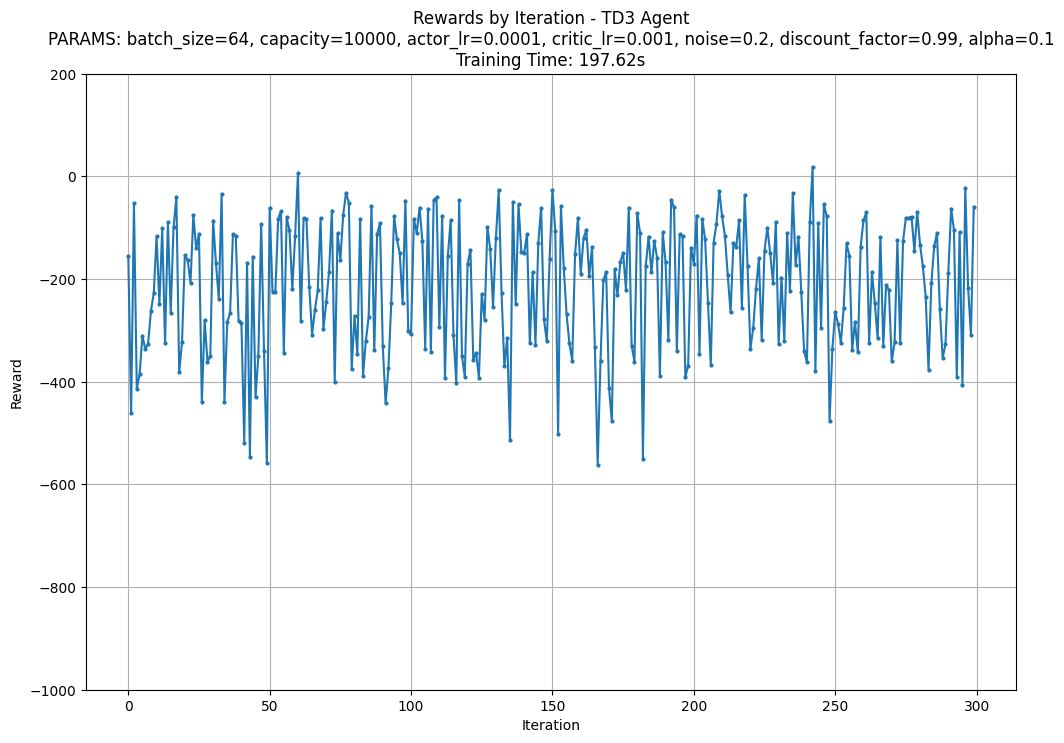

In [111]:
# PLOT RESULTS
plt.figure(figsize=(12, 8))
plt.plot(rewards, marker='o', markersize=2, label='Reward per Iteration')
plt.title(f'Rewards by Iteration - TD3 Agent\nPARAMS: {batch_size=}, {capacity=}, {actor_lr=}, {critic_lr=}, {noise=}, {discount_factor=}, {alpha=}\nTraining Time: {final_time:.2f}s')
plt.xlabel('Iteration')
plt.ylabel('Reward')
ylim_bottom, ylim_top = plt.ylim()
plt.ylim(-1000, max(200, ylim_top + 10))
plt.grid()
plt.show()

In [112]:
print("Saved TD3 agent model to 'params/best_td3_agent.pt'")
td3_agent.save(Path("params", "best_td3_agent.pt"))

Saved TD3 agent model to 'params/best_td3_agent.pt'


In [113]:
print("Loaded TD3 agent model from 'params/best_td3_agent.pt'")
td3_agent.load(Path("params", "best_td3_agent.pt"))

Loaded TD3 agent model from 'params/best_td3_agent.pt'


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

Episode 10 - Reward: -126.79 - Average Reward: -118.18 - Success Rate: 0.00%

Episode 20 - Reward: -118.28 - Average Reward: -128.54 - Success Rate: 0.00%

Episode 30 - Reward: -92.71 - Average Reward: -128.66 - Success Rate: 0.00%

Episode 40 - Reward: -148.55 - Average Reward: -127.67 - Success Rate: 0.00%

Episode 50 - Reward: -101.89 - Average Reward: -128.56 - Success Rate: 0.00%

Episode 60 - Reward: -110.36 - Average Reward: -128.88 - Success Rate: 0.00%

Episode 70 - Reward: -128.10 - Average Reward: -128.54 - Success Rate: 0.00%

Episode 80 - Reward: -144.47 - Average Reward: -128.69 - Success Rate: 0.00%

Episode 90 - Reward: -99.64 - Average Reward: -129.18 - Success Rate: 0.00%

Episode 100 - Reward: -124.17 - Average Reward: -128.89 - Success Rate: 0.00%

Finished running 100 episodes.
Average Reward over 100 episodes: -128.89
Success Rate over 100 episodes: 0.00%


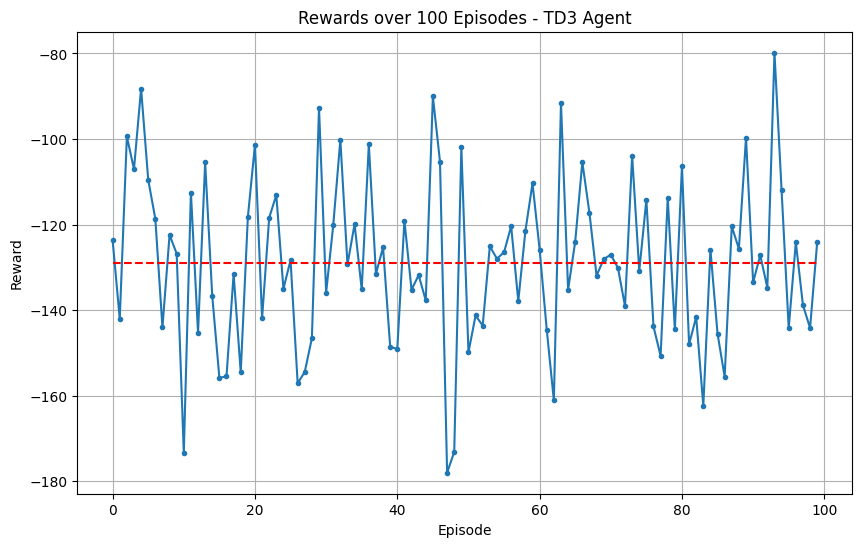

In [114]:
# run the trained td3 agent
max_episodes = 100
td3_agent_rewards, td3_agent_successes = run_agent_model(td3_agent, human_view=False, max_episodes=max_episodes, verbose=True, extra_verbose=False)
plt.figure(figsize=(10, 6))
plt.plot(td3_agent_rewards, marker='o', markersize=3)
# line for the final average
plt.plot([np.mean(td3_agent_rewards)] * len(td3_agent_rewards), linestyle='--', color='r')
plt.title(f'Rewards over {max_episodes} Episodes - TD3 Agent')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()

In [115]:
max_episodes = 3
td3_agent_rewards = run_agent_model(td3_agent, human_view=True, max_episodes=max_episodes, verbose=True, extra_verbose=False)

Episode 1 - Reward: -130.55 - Average Reward: -130.55 - Success Rate: 0.00%

Episode 2 - Reward: -93.88 - Average Reward: -112.22 - Success Rate: 0.00%

Finished running 2 episodes.
Average Reward over 2 episodes: -112.22
Success Rate over 2 episodes: 0.00%
